# Customer Satisfaction Prediction — ML (Industry Level)

**Project:** Customer Support Ticket Analytics  
**Notebook:** 02_ML_Model.ipynb  
**Input:** ../data/eda_clean.csv  

In [1]:
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    f1_score,
    roc_auc_score,
    roc_curve)

import joblib

sns.set_theme(style="whitegrid")

DATA_PATH = "../data/eda_clean.csv"
OUTPUT_DIR = "../outputs/ml_figures"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Output folder:", OUTPUT_DIR)

Output folder: ../outputs/ml_figures


## Load Dataset

In [2]:
df = pd.read_csv(DATA_PATH)
print("Loaded:", df.shape)
print(df.columns)
df.head()

Loaded: (8469, 17)
Index(['ticket_id', 'customer_name', 'customer_email', 'customer_age',
       'customer_gender', 'product_purchased', 'date', 'ticket_type',
       'ticket_subject', 'ticket_description', 'ticket_status', 'resolution',
       'priority', 'channel', 'first_response_time', 'time_to_resolution',
       'satisfaction_rating'],
      dtype='object')


,ticket_id,customer_name,customer_email,customer_age,customer_gender,product_purchased,date,ticket_type,ticket_subject,ticket_description,ticket_status,resolution,priority,channel,first_response_time,time_to_resolution,satisfaction_rating
0,1,Marisa Obrien,carrollallison@example.com,32,Other,GoPro Hero,2021-03-22,Technical issue,Product setup,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Social media,2023-06-01 12:15:36,NaN,NaN
1,2,Jessica Rios,clarkeashley@example.com,42,Female,LG Smart TV,2021-05-22,Technical issue,Peripheral compatibility,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Chat,2023-06-01 16:45:38,NaN,NaN
2,3,Christopher Robbins,gonzalestracy@example.com,48,Other,Dell XPS,2020-07-14,Technical issue,Network problem,I'm facing a problem with my {product_purchase...,Closed,Case maybe show recently my computer follow.,Low,Social media,2023-06-01 11:14:38,2023-06-01 18:05:38,3.0
3,4,Christina Dillon,bradleyolson@example.org,27,Female,Microsoft Office,2020-11-13,Billing inquiry,Account access,I'm having an issue with the {product_purchase...,Closed,Try capital clearly never color toward story.,Low,Social media,2023-06-01 07:29:40,2023-06-01 01:57:40,3.0
4,5,Alexander Carroll,bradleymark@example.com,67,Female,Autodesk AutoCAD,2020-02-04,Billing inquiry,Data loss,I'm having an issue with the {product_purchase...,Closed,West decision evidence bit.,Low,Email,2023-06-01 00:12:42,2023-06-01 19:53:42,1.0


## Column Schema Fixed

In [4]:
target = "satisfaction_rating"

text_subject = "ticket_subject"
text_desc = "ticket_description"

cat_cols = [
    "ticket_type", "priority", "channel", "ticket_status",
    "customer_gender", "product_purchased"
]

num_cols = ["customer_age", "first_response_time", "time_to_resolution"]

cat_cols = [c for c in cat_cols if c in df.columns]
num_cols = [c for c in num_cols if c in df.columns]

print("categorical:", cat_cols)
print("numeric:", num_cols)

categorical: ['ticket_type', 'priority', 'channel', 'ticket_status', 'customer_gender', 'product_purchased']
numeric: ['customer_age', 'first_response_time', 'time_to_resolution']


## Numeric Fix 


In [6]:
df[target] = pd.to_numeric(df[target], errors="coerce")

for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

df = df.dropna(subset=[target]).reset_index(drop=True)
df[target] = df[target].astype(int)

print("After target cleaning:", df.shape)
df[target].value_counts().sort_index()

After target cleaning: (2769, 17)


satisfaction_rating
1    553
2    549
3    580
4    543
5    544
Name: count, dtype: int64

## Text Feature Engineering

Combine subject + description for TF-IDF vectorization.

In [7]:
df["text_combined"] = (df[text_subject].astype(str) + " " + df[text_desc].astype(str)).str.lower()
df["text_combined"] = df["text_combined"].str.replace(r"[^a-z0-9\s]", " ", regex=True)
df["text_combined"] = df["text_combined"].str.replace(r"\s+", " ", regex=True).str.strip()

df["text_combined"].head()

0    network problem i m facing a problem with my p...
1    account access i m having an issue with the pr...
2    data loss i m having an issue with the product...
3    data loss i m having an issue with the product...
4    software bug i m having an issue with the prod...
Name: text_combined, dtype: object

## Train/Test Split

In [9]:
X = df[cat_cols + num_cols + ["text_combined"]]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (2215, 10) Test: (554, 10)


## Preprocessing + Model Pipelines

- categorical: impute + onehot
- numeric: median impute
- text: TF-IDF

In [10]:
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))])

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))])

text_transformer = Pipeline(steps=[
    ("tfidf", TfidfVectorizer(max_features=5000, stop_words="english"))])

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, cat_cols),
        ("num", numeric_transformer, num_cols),
        ("txt", text_transformer, "text_combined")])

In [11]:
Xt = preprocessor.fit_transform(X_train)

print("Transformed output type:", type(Xt))
print("Transformed output shape:", Xt.shape)

Transformed output type: <class 'scipy.sparse._csr.csr_matrix'>
Transformed output shape: (2215, 3213)


In [12]:
Xt = preprocessor.fit_transform(X_train)

print(Xt[:5].toarray())

[[0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


In [13]:
preprocessor.fit(X_train)

ohe = preprocessor.named_transformers_["cat"].named_steps["onehot"]
cat_feature_names = ohe.get_feature_names_out(cat_cols)

num_feature_names = np.array(num_cols)

tfidf = preprocessor.named_transformers_["txt"].named_steps["tfidf"]
tfidf_feature_names = tfidf.get_feature_names_out()

all_features = np.concatenate([cat_feature_names, num_feature_names, tfidf_feature_names])

print("Total features:", len(all_features))
print("First 30 features:\n", all_features[:30])

Total features: 3215
First 30 features:
 ['ticket_type_Billing inquiry' 'ticket_type_Cancellation request'
 'ticket_type_Product inquiry' 'ticket_type_Refund request'
 'ticket_type_Technical issue' 'priority_Critical' 'priority_High'
 'priority_Low' 'priority_Medium' 'channel_Chat' 'channel_Email'
 'channel_Phone' 'channel_Social media' 'ticket_status_Closed'
 'customer_gender_Female' 'customer_gender_Male' 'customer_gender_Other'
 'product_purchased_Adobe Photoshop' 'product_purchased_Amazon Echo'
 'product_purchased_Amazon Kindle' 'product_purchased_Apple AirPods'
 'product_purchased_Asus ROG' 'product_purchased_Autodesk AutoCAD'
 'product_purchased_Bose QuietComfort'
 'product_purchased_Bose SoundLink Speaker'
 'product_purchased_Canon DSLR Camera' 'product_purchased_Canon EOS'
 'product_purchased_Dell XPS' 'product_purchased_Dyson Vacuum Cleaner'
 'product_purchased_Fitbit Charge']


In [14]:
Xt = preprocessor.fit_transform(X_train)

df_out = pd.DataFrame(
    Xt[:, :100].toarray(),
    columns=all_features[:100]
)

df_out.head()

,ticket_type_Billing inquiry,ticket_type_Cancellation request,ticket_type_Product inquiry,ticket_type_Refund request,ticket_type_Technical issue,priority_Critical,priority_High,priority_Low,priority_Medium,channel_Chat,...,100033,10th,11,110549,11129,112,112merit,12,1215,12371312
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Logistic Regression Model

In [16]:
lr_clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(max_iter=2000))
])

lr_clf.fit(X_train, y_train)
print("Logistic Regression trained")

Logistic Regression trained


## RandomForest Model

In [17]:
rf_clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        class_weight="balanced"
    ))
])

rf_clf.fit(X_train, y_train)
print("RandomForest trained")

RandomForest trained


## Model Comparison
Compare using Accuracy + Weighted F1 + ROC-AUC (High rating >=4)

## Evaluate Function

In [18]:
def get_auc(model, X_test, y_test):
    y_bin = (y_test >= 4).astype(int)
    proba = model.predict_proba(X_test)

    high_idx = np.argmax(model.named_steps["model"].classes_)
    score = proba[:, high_idx]
    return roc_auc_score(y_bin, score)

def evaluate(name, model):
    pred = model.predict(X_test)
    acc = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred, average="weighted")
    auc = get_auc(model, X_test, y_test)
    return [name, acc, f1, auc]

results = []
results.append(evaluate("LogisticRegression", lr_clf))
results.append(evaluate("RandomForest", rf_clf))

results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "F1_Weighted", "ROC_AUC"])
results_df.sort_values(by="F1_Weighted", ascending=False)

,Model,Accuracy,F1_Weighted,ROC_AUC
1,RandomForest,0.205776,0.204567,0.517606
0,LogisticRegression,0.198556,0.198233,0.487768


## Select Best Model

In [19]:
best_model_name = results_df.sort_values(by="F1_Weighted", ascending=False).iloc[0]["Model"]
best_model = rf_clf if best_model_name == "RandomForest" else lr_clf

print("Best Model:", best_model_name)

Best Model: RandomForest


## Confusion Matrix

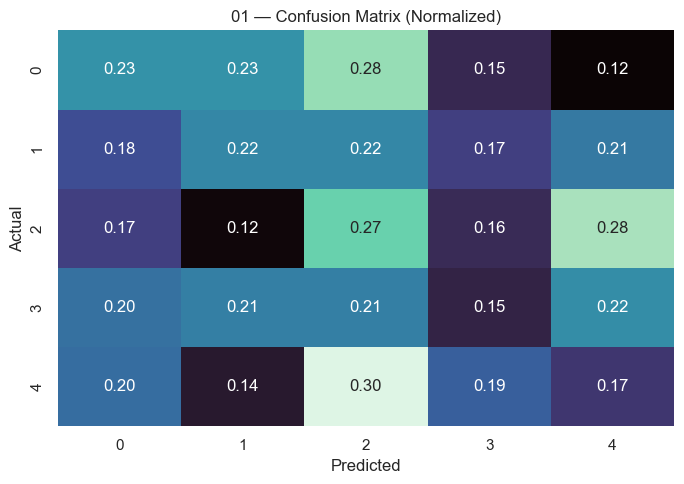

Saved: ../outputs/ml_figures\01_confusion_matrix.png


In [22]:
from sklearn.metrics import confusion_matrix

best_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, best_pred)
cm_norm = cm / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(7, 5))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="mako", cbar=False)
plt.title("01 — Confusion Matrix (Normalized)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()

save_path = os.path.join(OUTPUT_DIR, "01_confusion_matrix.png")
plt.savefig(save_path, dpi=300)
plt.show()

print("Saved:", save_path)

## ROC Curve

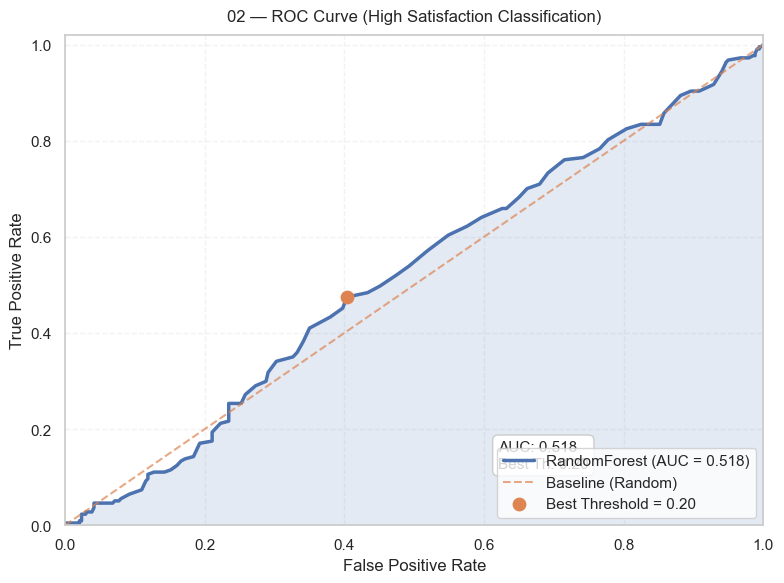

Saved: ../outputs/ml_figures\02_roc_curve.png


In [25]:
y_test_bin = (y_test >= 4).astype(int)

proba = best_model.predict_proba(X_test)

high_idx = np.argmax(best_model.named_steps["model"].classes_)

y_score = proba[:, high_idx]

auc = roc_auc_score(y_test_bin, y_score)

fpr, tpr, thresholds = roc_curve(y_test_bin, y_score)
j_scores = tpr - fpr

best_idx = np.argmax(j_scores)
best_threshold = thresholds[best_idx]
best_fpr, best_tpr = fpr[best_idx], tpr[best_idx]
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2.5, label=f"{best_model_name} (AUC = {auc:.3f})")
plt.fill_between(fpr, tpr, alpha=0.15)
plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1.5, alpha=0.7, label="Baseline (Random)")
plt.scatter(best_fpr, best_tpr, s=80, zorder=5, label=f"Best Threshold = {best_threshold:.2f}")
plt.text(
    0.62, 0.12,
    f"AUC: {auc:.3f}\nBest Th: {best_threshold:.2f}",
    fontsize=11,
    bbox=dict(boxstyle="round,pad=0.35", fc="white", ec="0.8"))

plt.title("02 — ROC Curve (High Satisfaction Classification)", pad=10)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True, linestyle="--", alpha=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])
plt.legend(loc="lower right")
plt.tight_layout()
save_path = os.path.join(OUTPUT_DIR, "02_roc_curve.png")
plt.savefig(save_path, dpi=300)
plt.show()

print("Saved:", save_path)

## Feature Importance

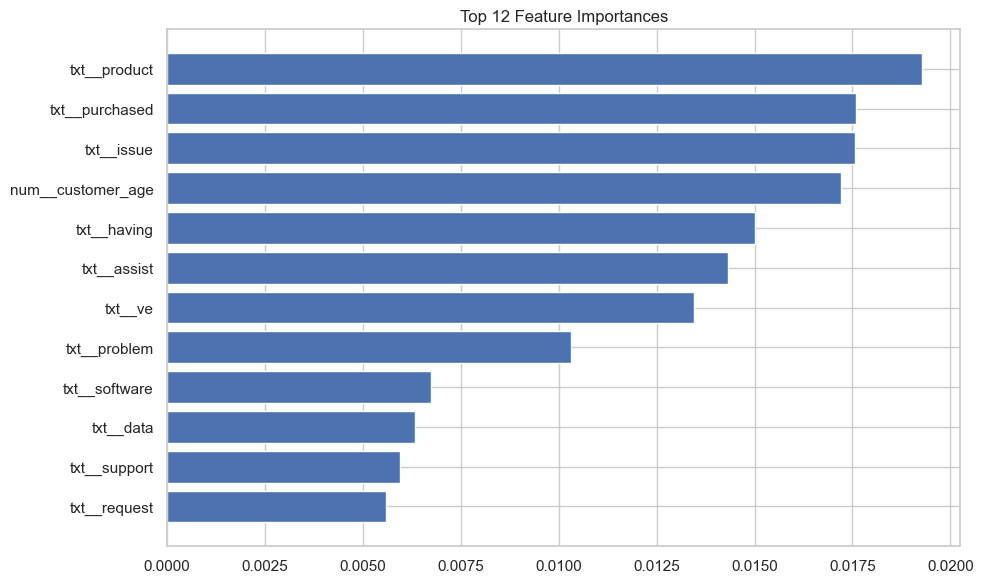

Saved: ../outputs/ml_figures/03_feature_importance.png


In [2]:
import joblib
import os

model_path = "../outputs/best_model.pkl"
model = joblib.load(model_path)

df = pd.read_csv("../data/eda_clean.csv")
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

target = None
for col in df.columns:
    if "satisfaction" in col and "rating" in col:
        target = col
        break

df = df.dropna(subset=[target])

X = df.drop(columns=[target])
y = df[target]

preprocessor = model.named_steps["preprocessor"]
clf = model.named_steps["model"]

feature_names = preprocessor.get_feature_names_out()

importances = clf.feature_importances_

feat_imp = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False).head(12)

plt.figure(figsize=(10,6))
plt.barh(feat_imp["feature"][::-1], feat_imp["importance"][::-1])
plt.title("Top 12 Feature Importances")
plt.tight_layout()

out_path = "../outputs/ml_figures/03_feature_importance.png"
os.makedirs("../outputs/ml_figures", exist_ok=True)
plt.savefig(out_path, dpi=200)
plt.show()

print("Saved:", out_path)

## Actual vs Predicted Distribution

Data loaded: (8469, 18)
✅ Target detected: customer_satisfaction_rating
✅ Rows after dropping NaN target: (2769, 18)
Numeric columns fixed safely: ['customer_age', 'first_response_time', 'time_to_resolution']
Missing column added: priority
Missing column added: channel
Model loaded
Predictions done


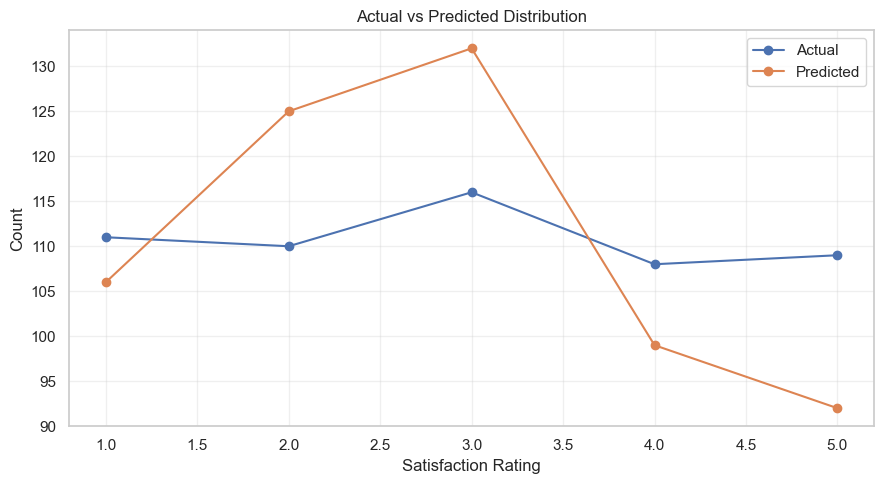

Saved: ../outputs/ml_figures/04_actual_vs_predicted.png


In [5]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split

df = pd.read_csv("../data/eda_clean.csv")

df.columns = (
    df.columns.str.strip()
    .str.lower()
    .str.replace(" ", "_"))

print("Data loaded:", df.shape)

target = None
for col in df.columns:
    if "satisfaction" in col and "rating" in col:
        target = col
        break

if target is None:
    raise ValueError("❌ Target column not found!")

print("✅ Target detected:", target)

df = df.dropna(subset=[target])
print("✅ Rows after dropping NaN target:", df.shape)

X = df.drop(columns=[target])
y = df[target]

numeric_cols = ["customer_age", "first_response_time", "time_to_resolution"]

for col in numeric_cols:
    if col in X.columns:
        # If column looks like datetime string -> try parsing
        temp_dt = pd.to_datetime(X[col], errors="coerce")

        if temp_dt.notna().sum() > 0:
            # Convert datetime to numeric: minutes since earliest date
            X[col] = (temp_dt - temp_dt.min()).dt.total_seconds() / 60
        else:
            # else force numeric
            X[col] = pd.to_numeric(X[col], errors="coerce")

print("Numeric columns fixed safely:", [c for c in numeric_cols if c in X.columns])

required_cols = ["priority", "channel"]

for col in required_cols:
    if col not in X.columns:
        X[col] = "Unknown"
        print(f"Missing column added: {col}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

model = joblib.load("../outputs/best_model.pkl")
print("Model loaded")

y_pred = model.predict(X_test)
print("Predictions done")

dist_df = pd.DataFrame({"Actual": y_test, "Predicted": y_pred})

actual_counts = dist_df["Actual"].value_counts().sort_index()
pred_counts = dist_df["Predicted"].value_counts().sort_index()
plt.figure(figsize=(9,5))
plt.plot(actual_counts.index, actual_counts.values, marker="o", label="Actual")
plt.plot(pred_counts.index, pred_counts.values, marker="o", label="Predicted")
plt.title("Actual vs Predicted Distribution")
plt.xlabel("Satisfaction Rating")
plt.ylabel("Count")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
os.makedirs("../outputs/ml_figures", exist_ok=True)
out_path = "../outputs/ml_figures/04_actual_vs_predicted.png"
plt.savefig(out_path, dpi=200)
plt.show()

print("Saved:", out_path)

In [11]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

# Load dataset
df = pd.read_csv("../data/eda_clean.csv")
print("Data loaded:", df.shape)

#  Normalize column names
df.columns = (
    df.columns.str.strip()
    .str.lower()
    .str.replace(" ", "_"))

#  Auto detect target
possible_targets = ["customer_satisfaction_rating", "satisfaction_rating", "csat"]
target = next((c for c in possible_targets if c in df.columns), None)
if target is None:
    raise ValueError("❌ Target column not found!")

print("Target detected:", target)

#  Drop NaN target rows
before = len(df)
df = df.dropna(subset=[target]).reset_index(drop=True)
print(" Dropped rows with NaN target:", before - len(df))

# REQUIRED COLS (for model)
required_cols = [
    "ticket_type",
    "priority",
    "ticket_status",
    "product_purchased",
    "channel",
    "customer_gender",
    "customer_age",
    "first_response_time",
    "time_to_resolution",
    "text_combined"]

# create text_combined if missing
if "text_combined" not in df.columns:
    if "ticket_subject" in df.columns and "ticket_description" in df.columns:
        df["text_combined"] = (
            df["ticket_subject"].astype(str).fillna("") + " " +
            df["ticket_description"].astype(str).fillna("")
        ).str.lower()
    else:
        df["text_combined"] = ""

# ensure missing cols exist
for c in required_cols:
    if c not in df.columns:
        df[c] = None
        print(f" Missing col created: {c}")


#  FIX NUMERIC COLUMNS 
df["customer_age"] = pd.to_numeric(df["customer_age"], errors="coerce")
df["first_response_time"] = pd.to_numeric(df["first_response_time"], errors="coerce")
df["time_to_resolution"] = pd.to_numeric(df["time_to_resolution"], errors="coerce")
df["first_response_time"] = df["first_response_time"].where(df["first_response_time"].notna(), None)
df["time_to_resolution"] = df["time_to_resolution"].where(df["time_to_resolution"].notna(), None)

print("Numeric columns fixed safely")

# Prepare X and y
X = df[required_cols]
y = df[target]

# drop rows where y missing
X = X.copy()
y = y.copy()

#  Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y)

# Load model and predict
best_model = joblib.load("../outputs/best_model.pkl")
print("✅ Model loaded")

y_pred = best_model.predict(X_test)
print("✅ Predictions generated")

# Metrics
accuracy = accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average="macro")
weighted_f1 = f1_score(y_test, y_pred, average="weighted")

# Low satisfaction recall (<=2)
y_true_low = (y_test <= 2).astype(int)
y_pred_low = (y_pred <= 2).astype(int)

low_recall = ((y_true_low & y_pred_low).sum() / y_true_low.sum()) if y_true_low.sum() != 0 else 0

# Save metrics
metrics_df = pd.DataFrame([{
    "Accuracy": round(accuracy, 4),
    "Macro_F1": round(macro_f1, 4),
    "Weighted_F1": round(weighted_f1, 4),
    "Low_Satisfaction_Recall": round(low_recall, 4)}])

metrics_df.to_csv("../outputs/ml_metrics.csv", index=False)
print("Saved metrics: ../outputs/ml_metrics.csv")
print(metrics_df)

Data loaded: (8469, 18)
Target detected: customer_satisfaction_rating
 Dropped rows with NaN target: 5700
 Missing col created: priority
 Missing col created: channel
Numeric columns fixed safely
✅ Model loaded
✅ Predictions generated
Saved metrics: ../outputs/ml_metrics.csv
   Accuracy  Macro_F1  Weighted_F1  Low_Satisfaction_Recall
0    0.1805    0.1788       0.1794                   0.3846
